In [7]:
import numpy as np
import pandas as pd
import math 
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
import csv
from scipy.spatial.distance import euclidean

In [8]:
all_data = pd.read_csv('all_data.csv')
load = np.array(all_data['net_demand_mwh'])
all_data.head()

,Date,Hr_End,RT_Demand,tot_solar_mwh,tot_wind_mwh,net_demand_mwh
0,1-Jan-22,1,117267.1781,0.0,5896.511745,111370.6664
1,1-Jan-22,2,118780.4624,0.0,5792.834164,112987.6283
2,1-Jan-22,3,122307.0229,0.0,5876.165118,116430.8578
3,1-Jan-22,4,127341.1629,0.0,5796.031289,121545.1316
4,1-Jan-22,5,131696.0562,0.0,6006.146647,125689.9095


In [9]:
power_rated = np.max(load)
n_hours = load.shape[0]
n_days = int(n_hours/24)
norm_power = load/power_rated

In [10]:
def find_scenarios(n_clusters,norm_power_single, random_state=None):
    cluster_size = [] # amount of data in each cluster/amount of all data
    kMeans = KMeans(n_clusters, random_state=random_state).fit(norm_power_single) # compute kmeans
    cId = kMeans.labels_ # vector of cluster IDs that the row belongs to
    centers = kMeans.cluster_centers_ # coordinate location for center of each cluster

    
    # Find the closest and furthest curves for each cluster
    normal_scenarios = []
    normal_index = []
    extreme_scenarios = []
    extreme_index = []

    for cluster_idx in range(n_clusters): 
        index_num = np.argwhere(cId == cluster_idx)
        cluster_size.append(len(index_num)) # Find the size of each cluster
        cluster_data = norm_power_single[cId == cluster_idx]  # Get data points in the current cluster
    
        # Calculate distances of each curve to the cluster center
        distances = [euclidean(curve, centers[cluster_idx]) for curve in cluster_data]
        # Find the index of the closest and furthest curve
        closest_curve_index = np.argmin(distances)
        furthest_curve_index = np.argmax(distances)
        
        # Store the closest and furthest curves
        normal_scenarios.append(cluster_data[closest_curve_index])
        extreme_scenarios.append(cluster_data[furthest_curve_index])
        normal_index.append(index_num[closest_curve_index])
        extreme_index.append(index_num[furthest_curve_index])

    return normal_scenarios,normal_index, extreme_scenarios, extreme_index, cluster_size, cId

In [11]:
n_clusters = 5
random_seed = 42
norm_power_single = np.reshape(norm_power[:], (n_days, 24)) 
normal_scenarios,normal_index,extreme_scenarios,extreme_index,cluster_size, cID = find_scenarios(n_clusters,norm_power_single,random_seed)
weights = [(cluster_size[0]-1)/n_days,(cluster_size[1] -1)/n_days,(cluster_size[2] -1)/n_days,(cluster_size[3] -1)/n_days,(cluster_size[4] -1)/n_days,1/n_days,1/n_days,1/n_days,1/n_days,1/n_days]

/Users/skhanal/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
with open('normal_scenarios.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(normal_scenarios)
    
with open('extreme_scenarios.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(extreme_scenarios)

with open('weights_of_scenarios.csv', 'w', newline='') as f:
    write = csv.writer(f)
    for val in weights:
        write.writerow([val])

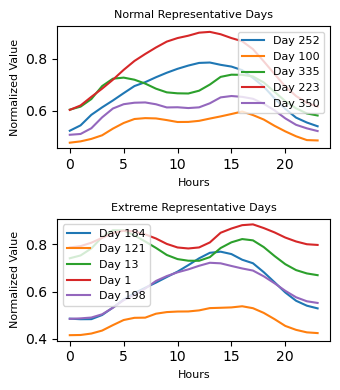

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming norm_power_single is a numpy array and normal_index, extreme_index are defined
normal_data = norm_power_single[[int(arr[0]) for arr in normal_index]]
extreme_data = norm_power_single[[int(arr[0]) for arr in extreme_index]]

# Set the figure size to fit within a single IEEE column width
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(3.5, 4))  # Adjust for a single column

# Define the font size for the title, labels, and legend
title_fontsize = 8
label_fontsize = 8
legend_fontsize = 8

# Plot normal data
for i, data in enumerate(normal_data):
    axs[0].plot(data, label=f'Day {normal_index[i][0]}')
axs[0].set_title('Normal Representative Days', fontsize=title_fontsize)
axs[0].set_xlabel('Hours', fontsize=label_fontsize)
axs[0].set_ylabel('Normalized Value', fontsize=label_fontsize)
axs[0].legend(prop={'size': legend_fontsize})

# Plot extreme data
for i, data in enumerate(extreme_data):
    axs[1].plot(data, label=f'Day {extreme_index[i][0]}')
axs[1].set_title('Extreme Representative Days', fontsize=title_fontsize)
axs[1].set_xlabel('Hours', fontsize=label_fontsize)
axs[1].set_ylabel('Normalized Value', fontsize=label_fontsize)
axs[1].legend(prop={'size': legend_fontsize})

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('representative_days.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()


In [14]:
normal_index

[array([252]), array([100]), array([335]), array([223]), array([350])]

In [15]:
extreme_index

[array([184]), array([121]), array([13]), array([1]), array([198])]

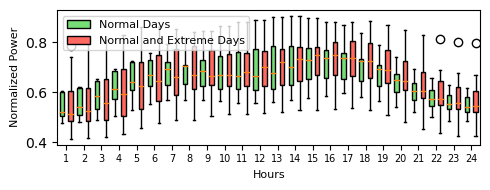

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming norm_power_single is a numpy array and normal_index, extreme_index are defined
# Here we extract the data for normal days and extreme days, based on the indices.
normal_data = np.array([norm_power_single[int(i)] for i in normal_index])
extreme_data = np.array([norm_power_single[int(i)] for i in extreme_index])

# Check if normal_data and extreme_data are lists of arrays. If so, convert them to 2D numpy arrays
if isinstance(normal_data[0], list):
    normal_data = np.array([np.array(entry) for entry in normal_data])
if isinstance(extreme_data[0], list):
    extreme_data = np.array([np.array(entry) for entry in extreme_data])

# Combine the data for plotting
combined_data = [normal_data[:, i].tolist() + extreme_data[:, i].tolist() for i in range(normal_data.shape[1])]

# Set the figure size to fit within a single IEEE column width
fig, ax = plt.subplots(figsize=(5, 2))  # IEEE single column size, height may vary

# Plotting
positions_normal = np.arange(1, 2*len(combined_data), 2)
positions_combined = np.arange(2, 2*len(combined_data) + 1, 2)
bp_normal = ax.boxplot(normal_data, positions=positions_normal, patch_artist=True, boxprops=dict(facecolor="#77dd77"))
bp_combined = ax.boxplot(combined_data, positions=positions_combined, patch_artist=True, boxprops=dict(facecolor="#ff6961"))

# Add some axis labels and customize ticks
ax.set_xlabel('Hours', fontsize=8)
ax.set_ylabel('Normalized Power', fontsize=8)
ax.set_xticks(np.arange(1.5, 2*len(combined_data), 2))
ax.set_xticklabels(range(1, len(combined_data) + 1), fontsize=7)  # Set x-ticks to show day index

# Optionally add a title
# ax.set_title('Normalized Power by Day Index', fontsize=9)

# Adjust the axis and grid
ax.axis('tight')

# Create legend
ax.legend([bp_normal["boxes"][0], bp_combined["boxes"][0]], ['Normal Days', 'Normal and Extreme Days'], loc='upper left', fontsize=8)

# Adjust the subplots layout to fit the figure size
plt.tight_layout()

# Save the figure as PNG
plt.savefig('representative_days_dist.png', format='png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


In [17]:
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import euclidean
import numpy as np

dbscan = DBSCAN(eps=0.15, min_samples=2).fit(norm_power_single) # compute DBSCAN
cId = dbscan.labels_  # vector of cluster IDs that the row belongs to
unique_clusters = set(cId)
unique_clusters

{-1, 0, 1}

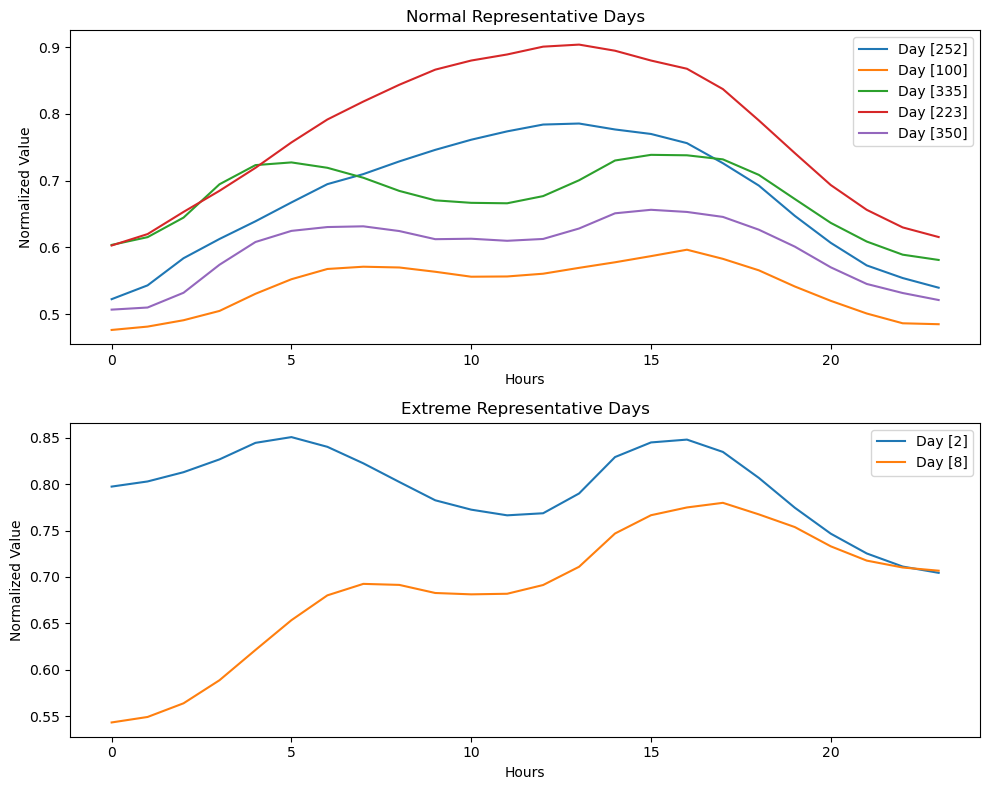

In [18]:
# Assuming norm_power_single is a numpy array and normal_index, extreme_index are defined
normal_data = norm_power_single[[int(arr[0]) for arr in normal_index]]
extreme_data = norm_power_single[np.where(cId == -1)[0]]

# Set up the figure and axes
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot normal data
for i, data in zip(normal_index, normal_data):
    axs[0].plot(data, label=f'Day {i}')
axs[0].set_title('Normal Representative Days')
axs[0].set_xlabel('Hours')
axs[0].set_ylabel('Normalized Value')
axs[0].legend()

# Plot extreme data
for i, data in zip(np.where(cId == -1)[0], extreme_data):
    axs[1].plot(data, label=f'Day [{i}]')
axs[1].set_title('Extreme Representative Days')
axs[1].set_xlabel('Hours')
axs[1].set_ylabel('Normalized Value')
axs[1].legend()

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('representative_days.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
